In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from samwich.dataloaders import RawData

In [3]:
from examples.turbines import Turbine  # container for turbine properties

`WakeTracker` is directly imported here to demonstrate common functions, including `remove_shear()` and plotting functions. 

Note that a normal workflow would utilize a derived WakeTracker class, e.g.,
through `samwich.waketrackers.track(method='Gaussian2D')` or, more directly, `from samwich.gaussian.Gaussian2DTracker import Gaussian2D`

In [4]:
from samwich.waketrackers import WakeTracker

# Calculating the deviation from the freestream
Written by [Eliot Quon](mailto:eliot.quon@nrel.gov) -- 2017-01-04

Definition of velocity components in SAMWICH Box: $u_{tot} = u_{avg} + u$

Wake tracking is performed on $u = -V_d$ where $V_d$ is the velocity deficit.

Note that the wake tracker is initialized with $u_{tot} \equiv u$. 

`WakeTracker.remove_shear(wind_profile=u_avg)` will calculate $u$ as $u_{tot} - u_{avg}$, where $u_{tot}$ is the input wake velocity field and $u_{avg}$ may be a:
- constant profile $u_{avg}(z)$,
- time-varying profile $u_{avg}(t,z)$, or
- time-varying inflow plane $u_{avg}(t,y,z)$.

In the absence of inflow data, freestream conditions may also be approximated by a power-law profile by calling:

`WakeTracker.remove_shear(alpha=alpha,Uref=Uref,zref=zref)`

or estimated from the edges of `Navg` planes of sampled data by 

`WakeTracker.remove_shear(method='fringe',Navg=Navg)`. 

Note that with the estimation approach, the freestream may vary over time and be sensitive to turbulence structures in the background flow.

## Setup

In [5]:
turb = Turbine('V27')
turb

V27
---
hub height: 32.1 m
diameter: 27 m
ref area: 572.555 m^2
ref CP: 0.588
ref CT: 0.84

In [6]:
datadir = os.path.join(os.environ['HOME'],'waketracking','reg_tests','MWE-data')
datadir

'/Users/equon/waketracking/reg_tests/MWE-data'

## Read in test data

In [7]:
sample = RawData(os.path.join(datadir,'snapshot_instantaneous_WFoR.csv'))

In [8]:
wake = WakeTracker(sample.sliceI())

Slicing data at i=0 x=2495.8
Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 2495.8 1633.2849999999999 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96499999999992 58.965000000000146
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing WakeTracker


Plot: frame 0

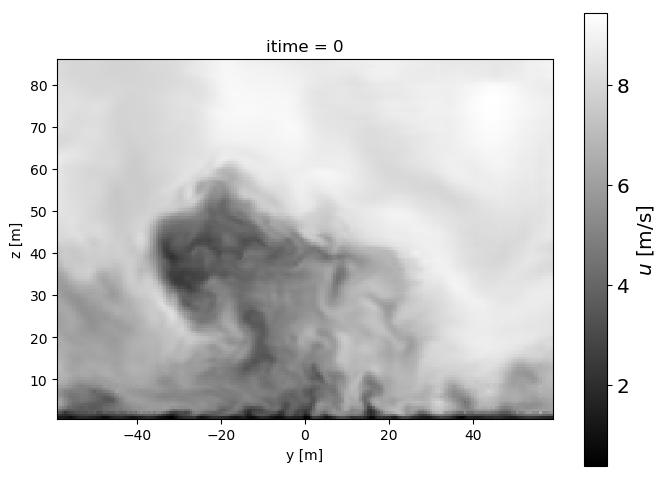

In [9]:
p = wake.plot()

## Freestream conditions

In [10]:
profile = np.loadtxt(os.path.join(datadir,'wind_profile.csv'), delimiter=',')
zprofile = profile[:,0]
Uprofile = profile[:,1]

In [11]:
Uref = np.interp(turb.zhub, zprofile, Uprofile)
Uref

6.837746550647215

In [12]:
# estimated
alpha = 0.23
Upowerlaw = Uref * (zprofile / turb.zhub)**alpha

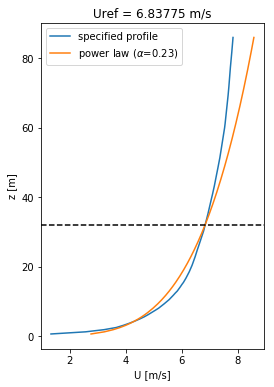

In [13]:
fig,ax = plt.subplots(figsize=(4,6))
ax.plot(Uprofile, zprofile, label='specified profile')
ax.plot(Upowerlaw, zprofile, label=r'power law ($\alpha$={:g})'.format(alpha))
ax.axhline(turb.zhub, color='k', ls='--')
ax.set_ylabel('z [m]')
ax.set_xlabel('U [m/s]')
ax.set_title('Uref = {:g} m/s'.format(Uref))
ax.legend(loc='upper left')

### Approach 1: Remove power law profile

In [14]:
wake.remove_shear(alpha=alpha, zref=turb.zhub, Uref=Uref)

  subtracting out profile (constant in time)


Plot: frame 0

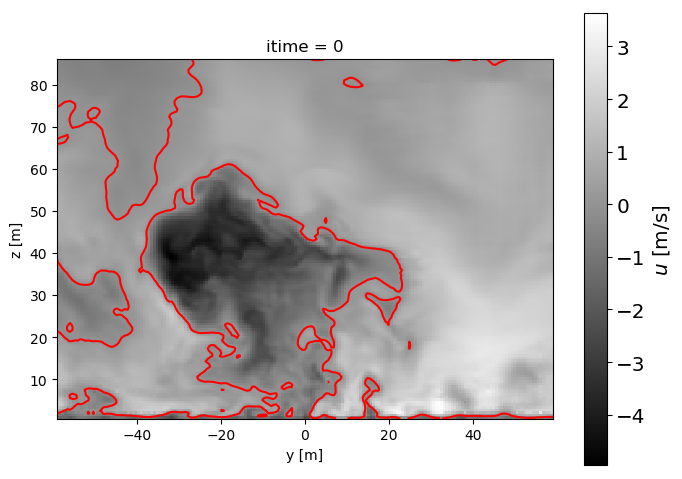

In [15]:
p = wake.plot()
p.ax.contour(wake.xh, wake.xv, wake.u[0,:,:], levels=[0], colors='r')

Note that wake tracking depends heavily on knowledge of the inflow to the turbine. If the velocity deficit is not well known, then the wake identification may fail.

### Approach 2: Remove specified profile

In [16]:
wake.remove_shear(wind_profile=profile)

remove_shear() was already called, doing nothing.


In [17]:
wake.shear_removal = None
wake.remove_shear(wind_profile=profile)

  subtracting out profile (constant in time)


Plot: frame 0

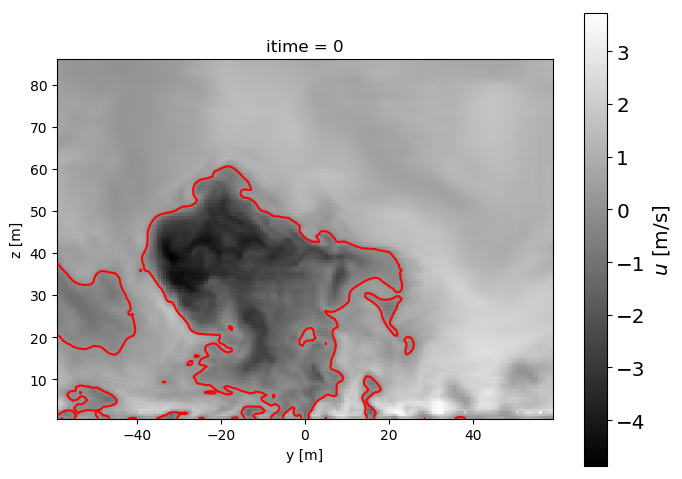

In [18]:
p = wake.plot()
p.ax.contour(wake.xh, wake.xv, wake.u[0,:,:], levels=[0], colors='r')